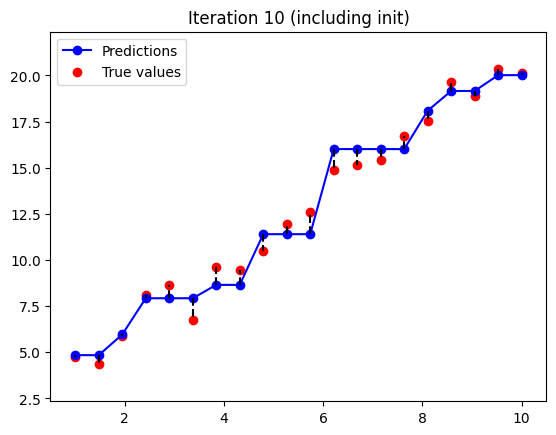

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# -------------------------------
# Parameters
# -------------------------------
np.random.seed(0)
x = np.linspace(1, 10, 20)
y = 2*x + 1 + np.random.normal(0, 1, size=x.shape)  # noisy linear data

nu = 0.5
n_rounds = 10
tree_depth = 1

# -------------------------------
# Fit 1D tree recursively
# -------------------------------
def fit_tree_1d(x, residuals, depth):
    if depth == 0 or len(x) <= 1:
        return [(None, None, residuals.mean())]  # leaf value as float
    
    best_split, best_score = None, np.inf
    for s in (x[:-1] + x[1:]) / 2:
        left_mask = x < s
        right_mask = x >= s
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            continue
        score = ((residuals[left_mask] - residuals[left_mask].mean())**2).sum() \
              + ((residuals[right_mask] - residuals[right_mask].mean())**2).sum()
        if score < best_score:
            best_score = score
            best_split = s
    
    if best_split is None:
        return [(None, None, residuals.mean())]
    
    left_mask = x < best_split
    right_mask = x >= best_split
    left_tree = fit_tree_1d(x[left_mask], residuals[left_mask], depth-1)
    right_tree = fit_tree_1d(x[right_mask], residuals[right_mask], depth-1)
    return [(best_split, left_tree, right_tree)]

# -------------------------------
# Predict with 1D tree
# -------------------------------
def predict_tree_1d(x_query, tree):
    split, left_tree, right_tree = tree[0]
    if split is None:
        # leaf node: return float
        return np.full_like(x_query, fill_value=right_tree, dtype=float) \
               if right_tree is not None else np.full_like(x_query, fill_value=left_tree, dtype=float)
    
    pred = np.zeros_like(x_query, dtype=float)
    left_mask = x_query < split
    right_mask = x_query >= split
    if left_mask.sum() > 0:
        pred[left_mask] = predict_tree_1d(x_query[left_mask], left_tree)
    if right_mask.sum() > 0:
        pred[right_mask] = predict_tree_1d(x_query[right_mask], right_tree)
    return pred

# -------------------------------
# Gradient Boosting Simulation
# -------------------------------
F = np.full_like(y, np.mean(y), dtype=float)
predictions = [F.copy()]
residuals_list = [y - F.copy()]

for m in range(n_rounds):
    residuals = y - F
    tree = fit_tree_1d(x, residuals, tree_depth)
    update = predict_tree_1d(x, tree)
    F += nu * update
    predictions.append(F.copy())
    residuals_list.append(y - F.copy())

# -------------------------------
# Animation Setup
# -------------------------------
fig, ax = plt.subplots()
ax.set_xlim(x.min()-0.5, x.max()+0.5)
ax.set_ylim(y.min()-2, y.max()+2)
line_pred, = ax.plot([], [], "bo-", label="Predictions")
ax.scatter(x, y, c="red", label="True values")
residual_lines = [ax.plot([], [], "k--")[0] for _ in x]
ax.legend()

def init():
    line_pred.set_data([], [])
    for rl in residual_lines:
        rl.set_data([], [])
    return [line_pred] + residual_lines

def update_anim(frame):
    y_pred = predictions[frame]
    line_pred.set_data(x, y_pred)
    for i, rl in enumerate(residual_lines):
        rl.set_data([x[i], x[i]], [y_pred[i], y[i]])  # vertical line residual
    ax.set_title(f"Iteration {frame} (including init)")
    return [line_pred] + residual_lines

ani = animation.FuncAnimation(fig, update_anim, frames=len(predictions),
                              init_func=init, blit=True, repeat=False)

HTML(ani.to_jshtml())